# Automated Bug Priority Predictor

## Overview
This project aims to develop a machine learning model that predicts the **priority level of software bug reports** based on their text descriptions and metadata.
By automating the triage process, software teams can save time and focus on resolving critical issues faster.

## Stack
- **Frontend:** Streamlit
- **Backend:** FastAPI
- **Database:** SQLite wit SQLAlchemy ORM
- **ML Environment:** Python (Jupyter Notebook, scikit-learn, pandas, nltk)
- **Datasets:** GitHub Issues Dataset and GitBugs/ms_vscode_bugs (Kaggle)
  - GitHub Issues: https://www.kaggle.com/datasets/davidshinn/github-issues?resource=download


---

# 02 Baseline Modeling

## Objective
In this notebook, we build and evaluate a baseline text classification model for predicting bug priority levels (`Critical`, `High`, `Medium`, `Low`) from issue text.

## Notebook Goals
1. Load the preprocessed data and TF-IDF features.
2. Train a baseline text classification model.
    - Naive Bayes
    - Logistic Regression
    - Random Forest Classifier
3. Evaluate performance.
    - Confusion matrix
    - Precision
    - Recall
    - F1-score
    - Classification report
4. Identify areas for improvement for future models.
5. Perform hyperparameter tuning with GridSearchCV or RandomizedSearchCV

In [ ]:
# Standard data libraries
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Optional ML DistilBERT

# Evaluation Metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, accuracy_score, recall_score, f1_score, classification_report

# Hyperparameter tuning
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

# Utilities
import joblib
from scipy.stats import randint

## Load Preprocessed Data and TF-IDF Features

In [64]:
processed_df = joblib.load("../../data/processed/processed_github_issues_df.joblib")
X = joblib.load("../../data/processed/tfidf/X_tfidf.joblib")
y = joblib.load("../../data/processed/tfidf/y_labels.joblib")

In [65]:
print("Shape of TF-IDF feature matrix (X): ", X.shape)
print("Shape of label vector (y): ", y.shape)

Shape of TF-IDF feature matrix (X):  (21241, 10000)
Shape of label vector (y):  (21241,)


In [66]:
processed_df.head()

,clean_text,word_count,priority
1,long string input commandline fail long string...,24,High
2,raster simulation rendering lw4 raster display...,116,Low
4,first reading adc without adc start adc temper...,122,Medium
7,retrieve booking specific customer id use case...,70,High
10,recognise bucket name using djangos3storage011...,145,High


In [67]:
y.head()

1       High
2        Low
4     Medium
7       High
10      High
Name: priority, dtype: object

In [68]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=y)

In [69]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (16992, 10000)
X_test shape: (4249, 10000)
y_train shape: (16992,)
y_test shape: (4249,)


In [70]:
y_train.value_counts(), y_test.value_counts()

(priority
 High        7716
 Low         4444
 Critical    2521
 Medium      2311
 Name: count, dtype: int64,
 priority
 High        1929
 Low         1111
 Critical     631
 Medium       578
 Name: count, dtype: int64)

In [71]:
# Check how many samples per class in training and test sets
train_counts = y_train.value_counts()
test_counts = y_test.value_counts()

# Get total samples in each split
train_total = len(y_train)
test_total = len(y_test)

# Convert counts to relative frequencies
train_percentages = round((train_counts / train_total) * 100, 1)
test_percentages = round((test_counts / test_total) * 100, 1)

In [72]:
# Compare distribution
comparison_table = pd.DataFrame({
  "Train %": train_percentages,
  "Test %": test_percentages
})
comparison_table

,Train %,Test %
priority,,
High,45.4,45.4
Low,26.2,26.1
Critical,14.8,14.9
Medium,13.6,13.6


## Train Baseline Models

- Naive Bayes
- Logistic Regression
- Random Forest Classifier

In [73]:
# Put models in a dictionary
models = {
  "Naive Bayes": MultinomialNB(),
  "Logistic Regression": LogisticRegression(),
  "Random Forest Classifier": RandomForestClassifier()
}

# Create a function to fit and score models
def fit_and_score(models, X_train, X_test, y_train, y_test):
  """
  Fit machine learning models on training data and evaluate their accuracy on test data.

  Args:
      models (dict): A dictionary of model name strings to instantiated model objects.
      X_train (array-like or sparse matrix): Training feature matrix.
      X_test (array-like or sparse matrix): Test feature matrix.
      y_train (array-like): Training labels.
      y_test (array-like): Test labels.

  Returns:
      dict: A dictionary mapping model names to their accuracy scores on the test set.
  """
  np.random.seed(42)
  model_scores = {}
  
  for name, model in models.items():
    model.fit(X_train, y_train)
    model_scores[name] = model.score(X_test, y_test)
  
  return model_scores

In [164]:
model_scores = fit_and_score(models=models,
                              X_train=X_train,
                              X_test=X_test,
                              y_train=y_train,
                              y_test=y_test)

model_scores

{'Naive Bayes': 0.6323840903742057,
 'Logistic Regression': 0.8199576370910803,
 'Random Forest Classifier': 0.875500117674747}

<Axes: >

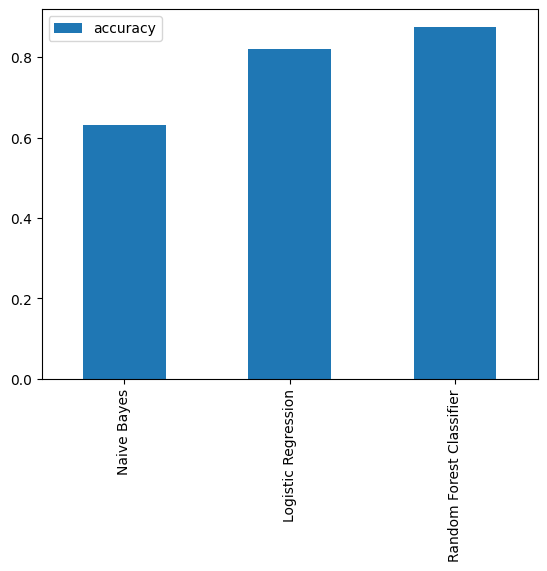

In [75]:
model_compare = pd.DataFrame(model_scores, index=["accuracy"])
model_compare.T.plot.bar()

## Evaluate performance

- Confusion matrix
- Precision
- Recall
- F1-score
- Classification report

(Optional)
- Accuracy
- Cross-validation
- Feature importance

In [101]:
def evalute_models(models, X_test, y_test, class_labels=None, plot_cm=True):
  """
  Evaluate multiple classification models on test data.

  Args:
      models (dict): Dictionary of trained models {name: model}.
      X_test: Test features.
      y_test: True labels.
      class_labels (list, optional): List of class names for confusion matrix. Defaults to None.
      plot_cm (bool, optional): Whether to display confusion matrices. Defaults to True.
      
  Returns:
    eval_df (DataFrame): Metrics for all models, sorted by weighted F1-score.
  """
  eval_results = []
  
  for name, model in models.items():
    y_pred = model.predict(X_test)
    
    cm = confusion_matrix(y_test, y_pred, labels=class_labels)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    if plot_cm:
      fig, ax = plt.subplots(figsize=(6,6))
      ax = sns.heatmap(cm_normalized, 
                      annot=True, 
                      fmt=".2f", 
                      cbar=False, 
                      xticklabels=["Critical", "High", "Medium", "Low"], 
                      yticklabels=["Critical", "High", "Medium", "Low"])
      
      plt.title(f"Confusion Matrix for {name}")
      plt.ylabel("True label")
      plt.xlabel("Predicted label")
      plt.show()

    precision = precision_score(y_test, y_pred, average='weighted')
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred, average='weighted')
    macro_f1 = f1_score(y_test, y_pred, average='macro')
    weighted_f1 = f1_score(y_test, y_pred, average='weighted')
    
    eval_results.append({
      "model": name,
      "precision": precision,
      "accuracy": accuracy,
      "recall": recall,
      "macro f1": macro_f1,
      "weighted f1": weighted_f1,
      "confusion_matrix": cm_normalized
    })
    
    print(f"Classification report for {name}")
    print(classification_report(y_test, y_pred))
    
  eval_df = pd.DataFrame(eval_results).sort_values(by="weighted f1", ascending=False)
  return eval_df

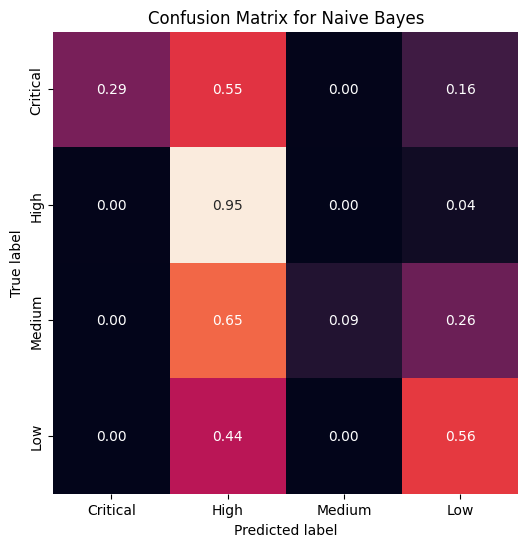

Classification report for Naive Bayes
              precision    recall  f1-score   support

    Critical       0.94      0.29      0.45       631
        High       0.60      0.95      0.74      1929
         Low       0.65      0.56      0.60      1111
      Medium       0.85      0.09      0.16       578

    accuracy                           0.63      4249
   macro avg       0.76      0.47      0.49      4249
weighted avg       0.70      0.63      0.58      4249



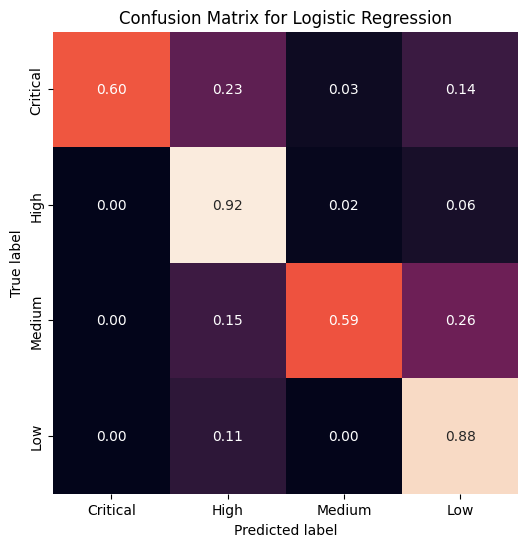

Classification report for Logistic Regression
              precision    recall  f1-score   support

    Critical       0.99      0.60      0.74       631
        High       0.84      0.92      0.88      1929
         Low       0.74      0.88      0.80      1111
      Medium       0.86      0.59      0.70       578

    accuracy                           0.82      4249
   macro avg       0.85      0.75      0.78      4249
weighted avg       0.84      0.82      0.81      4249



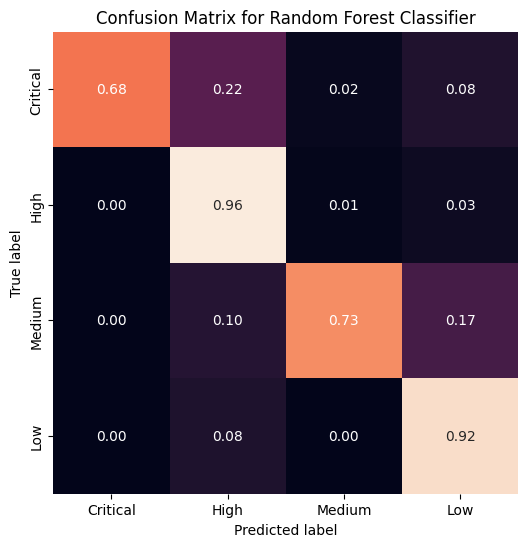

Classification report for Random Forest Classifier
              precision    recall  f1-score   support

    Critical       1.00      0.68      0.81       631
        High       0.87      0.96      0.91      1929
         Low       0.83      0.92      0.87      1111
      Medium       0.93      0.73      0.82       578

    accuracy                           0.88      4249
   macro avg       0.91      0.82      0.85      4249
weighted avg       0.88      0.88      0.87      4249



In [129]:
class_names = ["Critical", "High", "Medium", "Low"]
eval_df = evalute_models(
  models=models,
  X_test=X_test,
  y_test=y_test,
  class_labels=class_names,
  plot_cm=True
)

In [103]:
display(eval_df)

,model,precision,accuracy,recall,macro f1,weighted f1,confusion_matrix
2,Random Forest Classifier,0.884954,0.875500,0.875500,0.852235,0.872361,"[[0.6798732171156894, 0.2202852614896989, 0.02..."
1,Logistic Regression,0.835072,0.819958,0.819958,0.781469,0.814262,"[[0.5974643423137876, 0.2266244057052298, 0.03..."
0,Naive Bayes,0.699048,0.632384,0.632384,0.485812,0.579716,"[[0.29160063391442154, 0.5451664025356577, 0.0..."


In [104]:
pd.DataFrame([model_scores]).T

,0
Naive Bayes,0.632384
Logistic Regression,0.819958
Random Forest Classifier,0.875500


## Analysis of Baseline Model Performance

#### Model Comparison

I trained three baseline models: **Naive Bayes**, **Logistic Regression**, and **Random Forest Classifier**. Their overall performance metrics are summarized below:
| Model |	Precision |	Accuracy	| Recall	| Macro F1	| Weighted F1	|
| - | - | - | - | - | - |
|	Random Forest Classifier	| 0.885	| 0.876 |	0.876	| 0.852	| 0.872 |
|	Logistic Regression	| 0.835	| 0.819	| 0.819	| 0.781 |	0.814 |
|	Naive Bayes	| 0.699	| 0.632	| 0.632	| 0.486	| 0.579 |

**Insights:**
- **Random Forest** is the strongest baseline model overall.
- **Logistic Regression** performs reasonabliy well and is simpler to tune.
- **Naive Bayes** struggles, particularly with distinguishing between overlapping priority classes.

---

#### Confusion Matrix Analysis

Normalized confusion matrices highlight where models make mistakes:
- **Random Forest:** minor confusion between `Critical -> High` (22%) and `Medium -> Low` (17%).
- **Logistic Regression:** slightly higher confusion between `Critical -> High` (23%) and `Medium -> Low` (26%).
- **Naive Bayes:** high misclassification, especially `Critical -> High` (55%) and `Medium -> High` (65%).

**Observations:**
- Misclassifications often occur **between adjacent priority levels**, which is expected given the overlapping keyword patterns in the weak supervised label dataset.
- Random Forest handles feature interactions and overlapping keywords better than Naive Bayes.

---

#### Metric Insights

- **Accuracy** gives a general sense of overall performance but can  be misleading with imbalanced classes.
- **F1-score (macro and weighted)** is more informative for our imbalanced priority classes.
- **Precision and Recall:**
    - `Critical` and `High` predictions are slightly lower for Naive Bayes and Logistic Regression, indicating the model sometimes misses important bugs.
- Random Forest consistently achieves the highest weighted F1-score (0.872), balancing performance across all classes.

---

#### Conclusion

1. **Naive Bayes** is insufficient for this dataset due to overlapping text patterns and pseudo-label noise.
2. **Random Forest** is the best baseline model and should be the first candidate for hyperparameter tuning.
3. **Adjacent-class confusion** (`Critical <-> High`, `Medium <-> Low`) is the primary challenge, likely due to:
    - Keyword-based pseudo-labeling noise
    - Similar language used for bugs of slightly different priorities

## Hyperparameter Tuning with RandomizedSearchCV

- Logistic Regression
- Random Forest Classifier

In [105]:
model_scores

{'Naive Bayes': 0.6323840903742057,
 'Logistic Regression': 0.8199576370910803,
 'Random Forest Classifier': 0.875500117674747}

In [89]:
# Create a hyperparameter grid for Logistic Regression
log_reg_grid = {
  "C": np.logspace(-2, 2, 10),
  "penalty": ['l2'],
  "solver": ['lbfgs', 'saga'],
  "max_iter": [500, 600, 800, 1000]
}

# Tune Logistic Regression
np.random.seed(42)

rs_log_reg = RandomizedSearchCV(
  LogisticRegression(),
  param_distributions=log_reg_grid,
  n_iter=20,
  scoring="f1_weighted",
  cv=5,
  verbose=True,
  n_jobs=-1
)

rs_log_reg.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


,estimator,LogisticRegression()
,param_distributions,"{'C': array([1.0000...00000000e+02]), 'max_iter': [500, 600, ...], 'penalty': ['l2'], 'solver': ['lbfgs', 'saga']}"
,n_iter,20
,scoring,'f1_weighted'
,n_jobs,-1
,refit,True
,cv,5
,verbose,True
,pre_dispatch,'2*n_jobs'
,random_state,None
,error_score,nan


In [90]:
rs_log_reg.best_params_

{'solver': 'saga',
 'penalty': 'l2',
 'max_iter': 800,
 'C': np.float64(12.915496650148826)}

In [91]:
rs_log_reg.score(X_test, y_test)

0.8439470218170749

In [98]:
# Create a hyperparameter grid for Random Forest Classifier
rf_grid = {
  "n_estimators": [100, 200, 500],
  "max_depth": [None, 20, 30],
  "min_samples_split": [2, 5, 10],
  "min_samples_leaf": [1, 2, 4],
  "max_features": ["sqrt", "log2"],
  "bootstrap": [True, False]
}

# Tune Random Forest Classifier
np.random.seed(42)

rs_rf = RandomizedSearchCV(
  RandomForestClassifier(),
  param_distributions=rf_grid,
  n_iter=20,
  scoring="f1_weighted",
  cv=5,
  verbose=True,
  n_jobs=-1
)

rs_rf.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


,estimator,RandomForestClassifier()
,param_distributions,"{'bootstrap': [True, False], 'max_depth': [None, 20, ...], 'max_features': ['sqrt', 'log2'], 'min_samples_leaf': [1, 2, ...], ...}"
,n_iter,20
,scoring,'f1_weighted'
,n_jobs,-1
,refit,True
,cv,5
,verbose,True
,pre_dispatch,'2*n_jobs'
,random_state,None
,error_score,nan


In [99]:
rs_rf.best_params_

{'n_estimators': 500,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': None,
 'bootstrap': False}

In [100]:
rs_rf.score(X_test, y_test)

0.8882460810121144

In [183]:
tuned_scores = {
  "Logistic Regression (Tuned)": rs_log_reg.score(X_test, y_test),
  "Random Forest Classifier (Tuned)": rs_rf.score(X_test, y_test)
}
tuned_scores

{'Logistic Regression (Tuned)': 0.8439470218170749,
 'Random Forest Classifier (Tuned)': 0.8882460810121144}

In [168]:
tuned_models = {
  "Logistic Regression (Tuned)": rs_log_reg,
  "Random Forest Classifier (Tuned)": rs_rf
}

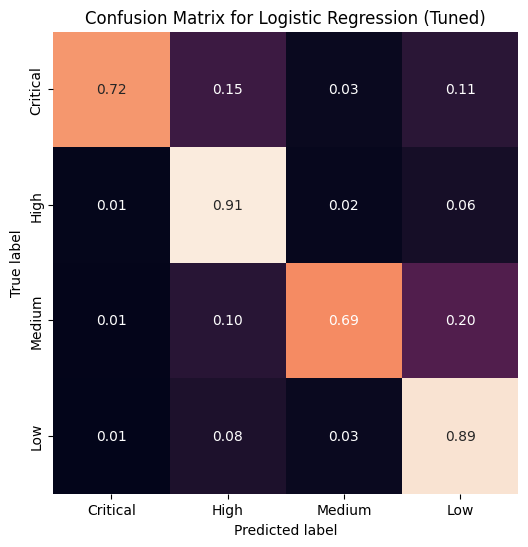

Classification report for Logistic Regression (Tuned)
              precision    recall  f1-score   support

    Critical       0.92      0.72      0.81       631
        High       0.88      0.91      0.89      1929
         Low       0.77      0.89      0.83      1111
      Medium       0.82      0.69      0.75       578

    accuracy                           0.85      4249
   macro avg       0.85      0.80      0.82      4249
weighted avg       0.85      0.85      0.84      4249



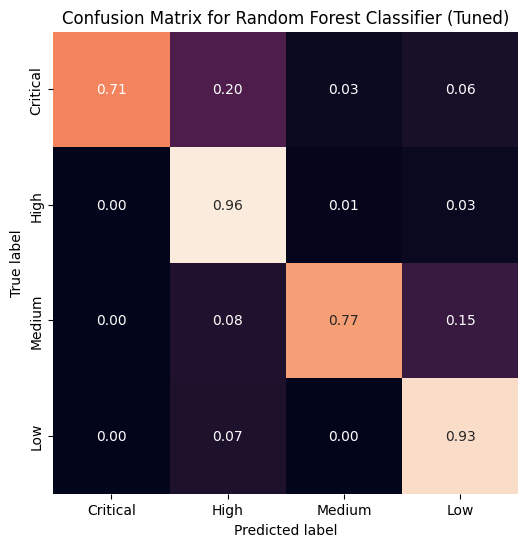

Classification report for Random Forest Classifier (Tuned)
              precision    recall  f1-score   support

    Critical       1.00      0.71      0.83       631
        High       0.88      0.96      0.92      1929
         Low       0.85      0.93      0.89      1111
      Medium       0.93      0.77      0.84       578

    accuracy                           0.89      4249
   macro avg       0.92      0.84      0.87      4249
weighted avg       0.90      0.89      0.89      4249



In [176]:
tuned_eval_df = evalute_models(
  tuned_models,
  X_test=X_test,
  y_test=y_test,
  class_labels=class_names,
  plot_cm=True
  )

In [177]:
display(tuned_eval_df)

,model,precision,accuracy,recall,macro f1,weighted f1,confusion_matrix
1,Random Forest Classifier (Tuned),0.897340,0.890562,0.890562,0.871283,0.888246,"[[0.7147385103011094, 0.196513470681458, 0.025..."
0,Logistic Regression (Tuned),0.849856,0.845611,0.845611,0.818927,0.843947,"[[0.716323296354992, 0.1473851030110935, 0.028..."


In [185]:
eval_df_baseline = eval_df[eval_df["model"] != "Naive Bayes"].copy()
eval_df_baseline = eval_df_baseline.drop(columns=['confusion_matrix'])
eval_df_baseline["Type"] = "Baseline"

eval_df_tuned = eval_df_tuned.copy()
eval_df_tuned = eval_df_tuned.drop(columns=['confusion_matrix'])
eval_df_tuned["Type"] = "Tuned"

In [186]:
eval_comparison_df = pd.concat([eval_df_baseline, eval_df_tuned], ignore_index=True)
display(eval_comparison_df)

,model,precision,accuracy,recall,macro f1,weighted f1,Type
0,Random Forest Classifier,0.884954,0.875500,0.875500,0.852235,0.872361,Baseline
1,Logistic Regression,0.835072,0.819958,0.819958,0.781469,0.814262,Baseline
2,Random Forest Classifier (Tuned),0.897340,0.890562,0.890562,0.871283,0.888246,Tuned
3,Logistic Regression (Tuned),0.849856,0.845611,0.845611,0.818927,0.843947,Tuned


## Save the Trained Models

In [188]:
joblib.dump(rs_rf, filename="../models/rs_random_forest_model_1.joblib")
print("Random Forest Classifier saved successfully!")

Random Forest Classifier saved successfully!


In [189]:
joblib.dump(rs_log_reg, filename="../models/rs_logistic_regression_model_1.joblib")
print("Logistic Regression saved successfully!")

Logistic Regression saved successfully!
